# Transfer Learning on American Sign Language

In [1]:
!pip install seaborn

import seaborn as sns

In [2]:
# set the python env so that we can use the project utils
import sys
sys.path.append("/home/studio-lab-user/sign-language-image-detection")

import tensorflow as tf
from pprint import pprint
from tqdm import tqdm
import matplotlib.pyplot as plt

import src.utils.keras_dataset_utils as keras_dataset_utils

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-01-12 11:58:43.173972: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  0


## Load Dataset

The dataset is structured into folders. Each folder has the name of the `label` and contains all relevant `images` of this label.

Train and Test set are also found into two separate folders.

This allows us to use the `image_dataset_from_directory` method from keras to quickly load the datase.

We __normalize__ the dataset and split it into:

- train set
- validation set (15% of the train set)
- test set


In [3]:
# A quick check to find the dimentionality of the images
from PIL import Image

img = Image.open("/home/studio-lab-user/sign-language-image-detection/sign_datasets/american_sign_language_dataset/ASL_Dataset/Train/A/1047.jpg")

print(f'Image dimentions: {img.size}')

Image dimentions: (400, 400)


In [5]:
dataset_path = "/home/studio-lab-user/sign-language-image-detection/sign_datasets/american_sign_language_dataset/ASL_Dataset/Train/"

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    # Resize the image to be compatible with MobileNet
    image_size=(224, 224),
    batch_size=64,
    shuffle=True
)

# The test dataset is under the test folder
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path.replace("/Train/", "/Test/"),
    # Resize the image to be compatible with MobileNet
    image_size=(224, 224),
    batch_size=64,
    shuffle=True
)

def normalize_image(image, label):
    # TODO: Calculate mean, std for the images
    precomputed_mean = [0.52732987, 0.4507709, 0.41209071]
    precomputed_std = [0.19798545, 0.23537221, 0.26049182]

    # Normalize the image
    image = (image / 255.0 - precomputed_mean) / precomputed_std
    return image, label

# Split the train into train and validation
train_size = int(0.85 * len(dataset))

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# TODO: Apply normalization

# Set performance settings
# Prefetch one batch at a time
buffer_size = 1
train_dataset = train_dataset.prefetch(buffer_size=buffer_size)
val_dataset = val_dataset.prefetch(buffer_size=buffer_size)
test_dataset = test_dataset.prefetch(buffer_size=buffer_size)


Found 165670 files belonging to 28 classes.
Found 112 files belonging to 28 classes.


## Visualizations

Bellow we can see some visualizations for this dataset

100%|██████████| 2200/2200 [02:17<00:00, 15.96it/s]


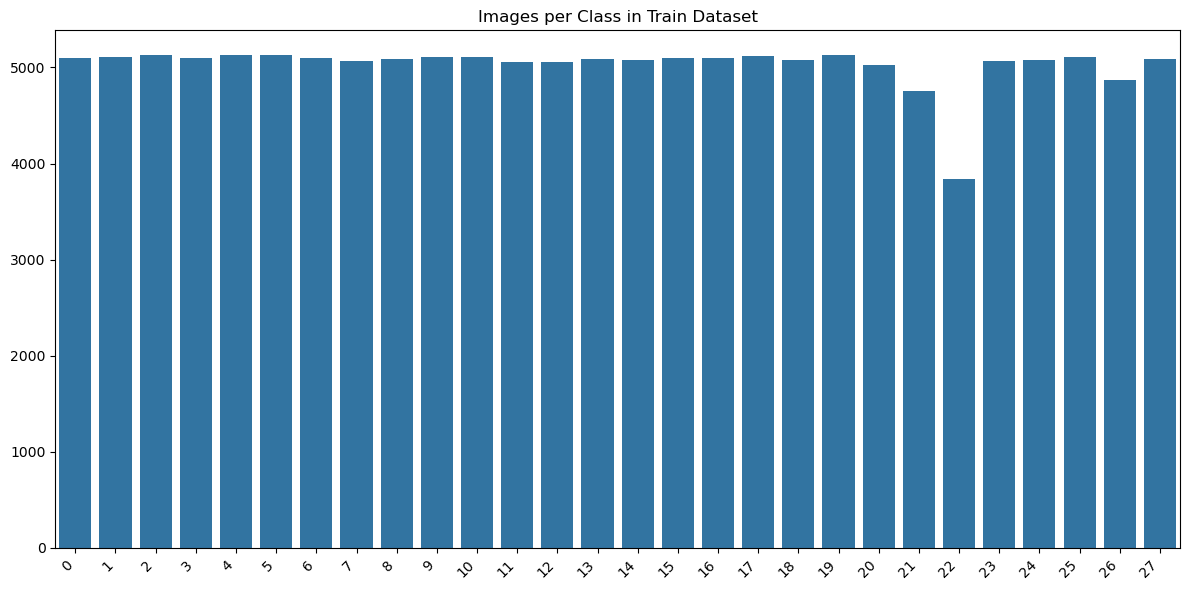

In [6]:
keras_dataset_utils.plot_class_distribution(train_dataset, "Images per Class in Train Dataset")

100%|██████████| 389/389 [03:16<00:00,  1.98it/s]  


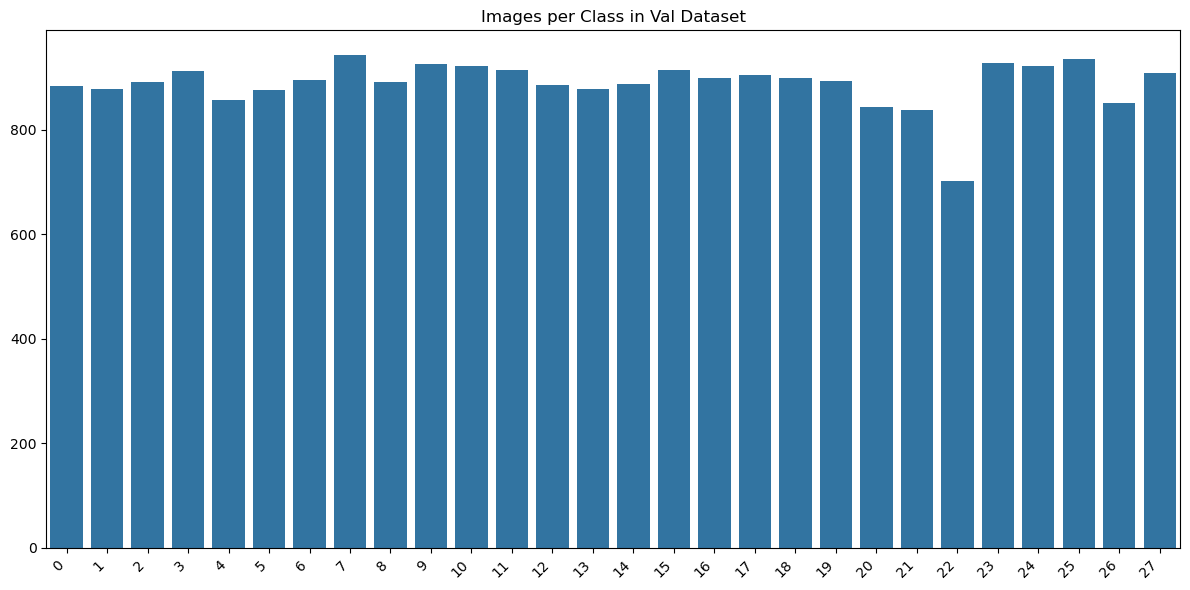

In [9]:
keras_dataset_utils.plot_class_distribution(val_dataset, "Images per Class in Val Dataset")

100%|██████████| 2/2 [00:00<00:00, 10.16it/s]


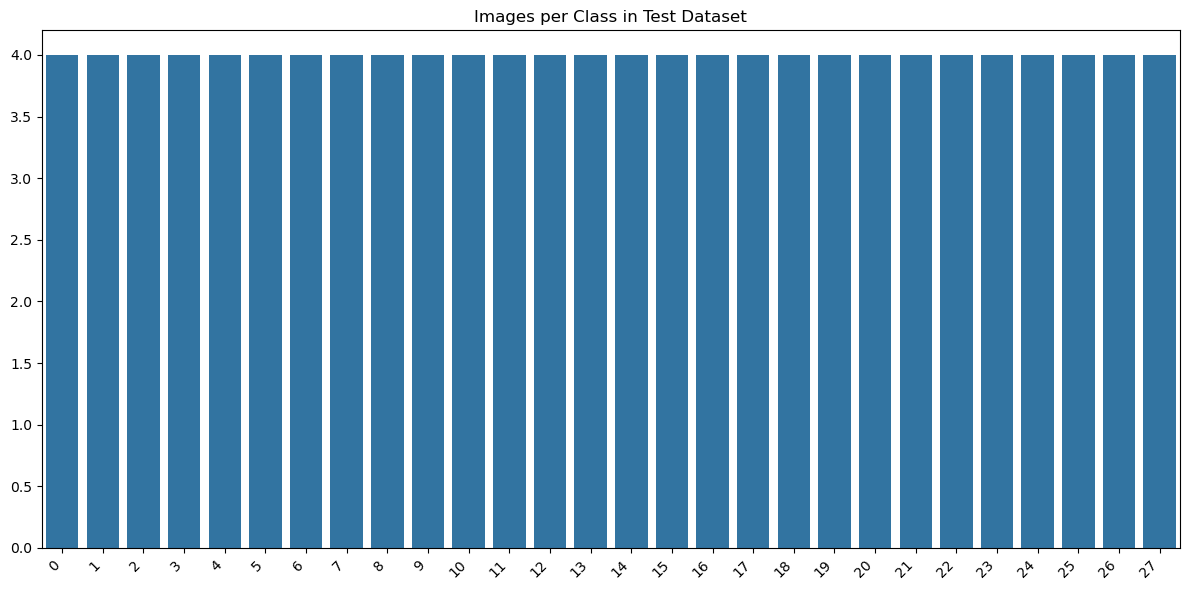

In [10]:
keras_dataset_utils.plot_class_distribution(test_dataset, "Images per Class in Test Dataset")

## MobileNet Transfer Learning

Let's try to finetune `MobileNetV2` for our task.

MobileNetV2 is trained on the `imagenet` dataset.

Due to the fact that it works with some specific image sizes, we have to reshape our images from (400, 400) to (224, 244)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
# we dont want to train the base model
base_model.trainable = False

class_names = dataset.class_names

# Add custom layers on top of the base model
model = tf.keras.Sequential([
    base_model,
    # This is added to reduce the number of parameters
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(516, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 516)               660996    
                                                                 
 dropout (Dropout)           (None, 516)               0         
                                                                 
 dense_1 (Dense)             (None, 28)                14476     
                                                                 
Total params: 2933456 (11.19 MB)
Trainable params: 67547

In [ ]:
history

## EfficientNet Transfer Learning

Let's try to finetune `EfficientNetB7` for our task.

EfficientNetB7 is trained on the `imagenet` dataset.

In [ ]:
base_model = tf.keras.applications.EfficientNetB7(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
# we dont want to train the base model
base_model.trainable = False

class_names = dataset.class_names

# Add custom layers on top of the base model
model = tf.keras.Sequential([
    base_model,
    # This is added to reduce the number of parameters
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(516, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=1)